In [1]:
#pip install openpyxl for reading excel
#!pip install fuzzywuzzy 
#!pip install openpyxl==3.1.0
#!pip install python-Levenshtein
# !pip install nltk

In [2]:
import codeUtils as utils
import data_cleaning as dc
import pandas as pd
import data_preprocessing as dp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

2025-06-14 22:52:51.015075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-14 22:52:51.026399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749918171.040703  250010 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749918171.044929  250010 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749918171.054782  250010 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# cleaning data
dc.main() # done analyzing the code

The first step in our pipeline involves loading the data into a pandas DataFrame. This is accomplished using the pandas library, which is imported at the beginning of the script.

In [4]:
# Step 1: Load the data

df = pd.read_csv('./data/MMNames_clean.csv')

In [5]:
# Step 2: Prepare the data

df,category_mapping = dp.preprocess_category(df,'SR_Name')
df = dp.preprocess_onehot(df,'name')


y = df['SR_Name'].values 
X = df.drop(columns=['SR_Name']).values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)


(13659, 13003) (5854, 13003)


In [6]:
# Step 3: Build a NN model with TensorFlow

# def create_classification_model(input_shape, num_classes, params={}):
#     model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer(shape=input_shape),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(16, activation='relu'),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])

#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#     return model

In [7]:
models_config={
    # ## i will use input later rather than hardcoding.
        "Initial Model":{
            "neurons":[32,16],
            "activation":["relu","relu"],
            "Description":"Intial_layers",
            "epochs":50,
            "batch_size":32,
            "optimizer":"adam",
            "loss":"sparse_categorical_crossentropy",
            "metrics":["accuracy"]

        },
        # "Model1_Layer3":{
        #     "neurons":[64,32],
        #     "activation":["relu"],
        #     "Description":"Model1_Layer3",
        #     "epochs":10,
        #     "batch_size":8,
        #     "optimizer":"adam",
        #     "loss":"sparse_categorical_crossentropy",
        #     "metrics":["accuracy"]
        # }
    
}

In [8]:



## well ... I want to run multiple model at the same time and compare. 
def train_classification_models(X_train,X_test,y_train,y_test,models_config):
    histories={}
    input_shape=X_train.shape[1]
    num_classes=len(np.unique(y_train))
    training_times={}
    models={}
    for model_name,config in models_config.items():
        print(f"----- Training Model : {model_name} -----" )
        model=tf.keras.Sequential() 
        activations=config.get("activation","relu")
        neurons=config.get("neurons",[32,16])

        epochs=config.get("epochs", 10)
        batch_size=config.get("batch_size",8)
        optimizer=config.get("optimizer","adam")
        loss=config.get("loss", "sparse_categorical_crossentropy")
        metrics=config.get("metrics", ["accuracy"])

        if len(activations)<len(neurons):
            activations +=[activations[-1]]*(len(neurons)-len(activations)) # the last activation "relu"* len(3-1)= [relu,relu]


        model.add(tf.keras.layers.InputLayer(shape=(input_shape,)) )

        for n,act in zip(neurons,activations):
            model.add(tf.keras.layers.Dense(n,activation=act))
        model.add(tf.keras.layers.Dense(num_classes,activation="softmax"))

        model.compile(optimizer=optimizer, loss=loss,metrics=metrics)
        start=time.time()
        histories[model_name]= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
        end=time.time()
        training_time=end-start
        # model.save(f"model/{model_name}.keras") 
        training_times[model_name]=training_time
        models[model_name]=model
    return histories,training_times,models




In [9]:
histories,training_times,models=train_classification_models(X_train,X_test,y_train,y_test,models_config)


----- Training Model : Initial Model -----


I0000 00:00:1749918178.079695  250010 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1522 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1749918179.295681  250522 service.cc:152] XLA service 0x733238003c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749918179.295711  250522 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-06-14 22:52:59.310708: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749918179.406982  250522 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-06-14 22:53:00.910147: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_129', 4484

In [10]:
for name, model in models.items(): 
    print(name)
    model.summary()
    print(f"Training Time : {training_times[name]}\n")


Initial Model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │       416,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,888 (4.77 MB)

 Trainable params: 416,962 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 833,926 (3.18 MB)

Training Time : 52.009610652923584



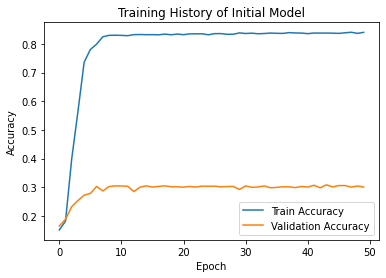

In [11]:

for name,history in histories.items():

    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.title(f"Training History of {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

In [12]:
# Step 5: Evaluate the model

# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score


# y_pred = model.predict(X_test, batch_size=32, verbose=0)
# y_pred = y_pred.argmax(axis=1)
# report = classification_report(y_test, y_pred, output_dict=True)
# report_df = pd.DataFrame(report).round(2).transpose()
# report_df.to_csv('./data/cls_report_test.csv', index=False)

# y_pred = model.predict(X_train, batch_size=32, verbose=0)
# y_pred = y_pred.argmax(axis=1)

# report = classification_report(y_train, y_pred, output_dict=True)
# report_df = pd.DataFrame(report).round(2).transpose()
# report_df.to_csv('./data/cls_report_train.csv', index=False)


In [13]:

# y_test_report_path="./data/cls_report1_test.csv"
y_train_pred = models["Initial Model"].predict(X_train, batch_size=32, verbose=0)
y_train_pred = y_train_pred.argmax(axis=1)
report = classification_report(y_train, y_train_pred, output_dict=True)
report_df = pd.DataFrame(report).round(2).transpose()
print("Initial Model Training Metrics")
report_df


Initial Model Training Metrics


,precision,recall,f1-score,support
0,0.91,0.81,0.86,1561.00
1,0.84,0.79,0.81,648.00
2,0.61,0.91,0.73,571.00
3,0.99,0.99,0.99,434.00
4,0.94,0.92,0.93,620.00
5,0.98,0.95,0.97,174.00
6,0.88,0.93,0.90,381.00
7,0.76,0.90,0.82,1580.00
8,0.85,0.80,0.82,1334.00
9,0.94,0.79,0.86,401.00


In [14]:

# y_test_report_path="./data/cls_report1_test.csv"
y_test_pred = models["Initial Model"].predict(X_test, batch_size=32, verbose=0)
y_test_pred = y_test_pred.argmax(axis=1)
report = classification_report(y_test, y_test_pred, output_dict=True)
report_df = pd.DataFrame(report).round(2).transpose()
print("Initial Model Testing Metrics")
report_df


Initial Model Testing Metrics


,precision,recall,f1-score,support
0,0.56,0.20,0.30,617.0
1,0.35,0.14,0.20,273.0
2,0.25,0.22,0.23,243.0
3,0.95,0.18,0.30,214.0
4,0.64,0.17,0.27,258.0
5,0.89,0.15,0.25,54.0
6,0.53,0.19,0.28,171.0
7,0.45,0.29,0.35,664.0
8,0.44,0.20,0.27,569.0
9,0.66,0.24,0.35,199.0


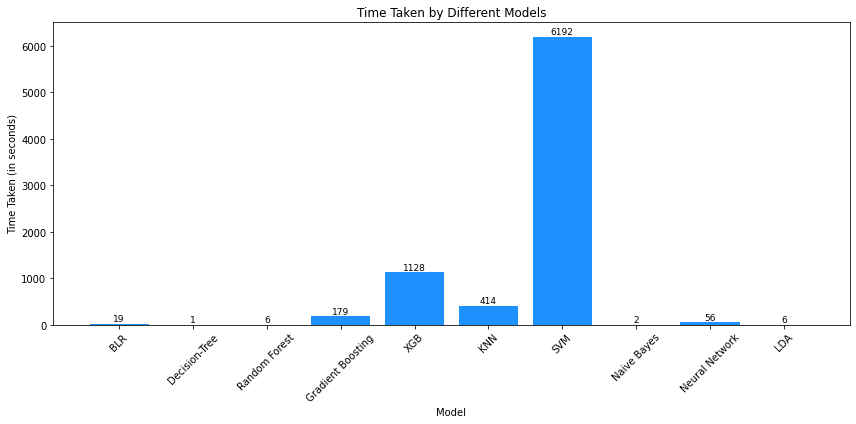

In [16]:

models = ['BLR', 'Decision-Tree', 'Random Forest', 'Gradient Boosting',
          'XGB', 'KNN', 'SVM', 'Naive Bayes', 'Neural Network', 'LDA']
times = [18.6, 1.12, 5.74, 179.4, 1128, 414, 6192, 2.16, 56, 6.42]

plt.figure(figsize=(12, 6))
bars = plt.bar(models, times, color='dodgerblue')

plt.xlabel('Model')
plt.ylabel('Time Taken (in seconds)')
plt.title('Time Taken by Different Models')

# Optionally annotate each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval:.0f}', ha='center', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:

    reverse_mapping = {v: k for k, v in category_mapping.items()}

    y_true = [reverse_mapping[i] for i in y_test]
    y_pred = [reverse_mapping[i] for i in y_test_pred]

    labels = list(category_mapping.values())

    cm = confusion_matrix(y_true, y_pred,labels=labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                xticklabels=labels, yticklabels=labels)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

KeyError: 11